# Smart Traffic Light - IoT Project

In [ ]:
# Import stantment
import cv2
import numpy as np
import socket
import time
from pathlib import Path
from ultralytics import YOLO
from collections import deque
import matplotlib.pyplot as plt


# Constant stantment
IMAGE1   = "../images/queue1.png" 
IMAGE2   = "../images/queue2.png"
VEHICLES = {"car", "truck", "bus", "motorbike"}

STOPLIGHT_1 = 0
STOPLIGHT_2 = 0

HOST = "192.168.4.1"   
PORT = 8080

MIN_GREEN = 10.0
MAX_GREEN = 45.0
YELLOW = 3.0
ALL_RED = 1.0
DIFF_THRESHOLD = 1
WINDOW = 5
FPS_SLEEP = 0.1

PH_LEFT_GREEN = "LEFT_GREEN"
PH_RIGHT_GREEN = "RIGHT_GREEN"
PH_YELLOW_LEFT = "YELLOW_LEFT"
PH_YELLOW_RIGHT = "YELLOW_RIGHT"
PH_ALL_RED = "ALL_RED"

In [51]:
def send(cmd : str) -> None:
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.settimeout(3)
        s.connect((HOST, PORT))
        s.sendall((cmd + "\n").encode())
        try:
            print(cmd, "->", s.recv(64).decode().strip())
        except Exception:
            print(cmd, "-> (no resp)")

for cmd in ["R1","Y1","G1","R2","Y2","G2"]:
    send(cmd); time.sleep(0.8)

for cmd in ["S:GR","S:RG","S:YY","S:RR","S:GG"]:
    send(cmd); time.sleep(0.8)

send("ALL:OFF")

R1 -> ACK R1
Y1 -> ACK Y1
G1 -> ACK G1
R2 -> ACK R2
Y2 -> ACK Y2
G2 -> ACK G2
S:GR -> ACK S:XY
S:RG -> ACK S:XY
S:YY -> ACK S:XY
S:RR -> ACK S:XY
S:GG -> ACK S:XY
ALL:OFF -> ACK ALL:OFF


In [44]:
class VisionCounter:
    def __init__(self, weights="yolov8n.pt", conf=0.3):
        self.model = YOLO(weights)
        self.conf = conf

    def count(self, frame):
        """
        Count the vehicles in the whole frame.

        Returns:
            int: total number of vehicles detected in the frame.
        """
        res = self.model(frame, conf=self.conf, verbose=False)[0]
        n = 0
        for b in res.boxes:
            cls_id = int(b.cls[0])
            name = self.model.names[cls_id]
            if name in VEHICLES:
                n += 1
        return n

In [45]:
def _read_image(path_str):
    p = Path(path_str)
    if not p.exists():
        raise FileNotFoundError(f"Image not found: {p}")
    img = cv2.imread(str(p))
    if img is None:
        raise ValueError(f"Non readble image: {p}")
    return img

In [46]:
vc = VisionCounter()
img1 = _read_image(IMAGE1)
img2 = _read_image(IMAGE2)

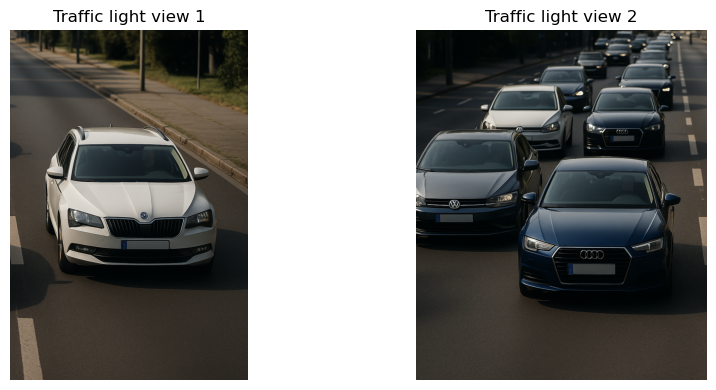

In [2]:
plt1 = cv2.imread(IMAGE1)
plt2 = cv2.imread(IMAGE2)

plt1 = cv2.cvtColor(plt1, cv2.COLOR_BGR2RGB)
plt2 = cv2.cvtColor(plt2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.imshow(plt1)
plt.title("Traffic light view 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(plt2)
plt.title("Traffic light view 2")
plt.axis("off")

plt.tight_layout()
plt.show()

In [47]:
STOPLIGHT_1 = vc.count(img1)
STOPLIGHT_2 = vc.count(img2) 

print(f"Spotlight 1: {STOPLIGHT_1} car(s)\nSpotlight 2: {STOPLIGHT_2} car(s)")

Spotlight 1: 1 car(s)
Spotlight 2: 9 car(s)


In [ ]:
class ArduinoClient:
    def __init__(self, host=HOST, port=PORT, timeout=5):
        self.host = host
        self.port = port
        self.timeout = timeout
        self.sock = None
        self.connect()
    def connect(self):
        self.close()
        s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        s.settimeout(self.timeout)
        s.connect((self.host, self.port))
        self.sock = s
    def close(self):
        if self.sock:
            try: self.sock.close()
            except: pass
        self.sock = None
    def send_cmd(self, cmd):
        try:
            if not self.sock:
                self.connect()
            self.sock.sendall((cmd + "\n").encode("utf-8"))
            data = self.sock.recv(1024)
            return data.decode("utf-8", errors="ignore").strip()
        except:
            self.connect()
            self.sock.sendall((cmd + "\n").encode("utf-8"))
            data = self.sock.recv(1024)
            return data.decode("utf-8", errors="ignore").strip()

arduino = None

In [49]:
def set_phase(phase):
    if not arduino:
        return
    if phase == PH_LEFT_GREEN:
        arduino.send_cmd("S:GR")
    elif phase == PH_RIGHT_GREEN:
        arduino.send_cmd("S:RG")
    elif phase == PH_YELLOW_LEFT:
        arduino.send_cmd("S:YR")
    elif phase == PH_YELLOW_RIGHT:
        arduino.send_cmd("S:RY")
    elif phase == PH_ALL_RED:
        arduino.send_cmd("ALL:RED")

def smooth_push(dq, val, window=WINDOW):
    dq.append(val)
    if len(dq) > window:
        dq.popleft()
    return sum(dq) / max(1, len(dq))

In [55]:
def main():
    global arduino
    arduino = ArduinoClient()
    vc = VisionCounter(weights="yolov8n.pt", conf=0.35)
    
    queue1 = cv2.imread("../images/queue1.png")
    queue2 = cv2.imread("../images/queue2.png")
    if queue1 is None or queue2 is None:
        print("Errore: immagini queue1.jpg / queue2.jpg non trovate.")
        return

    left_hist, right_hist = deque(), deque()
    phase = PH_LEFT_GREEN
    last_switch = time.time()
    set_phase(phase)
    
    try:
        while True:
            n_left = vc.count(queue1)
            n_right = vc.count(queue2)

            sm_left = smooth_push(left_hist, n_left)
            sm_right = smooth_push(right_hist, n_right)

            now = time.time()
            green_elapsed = now - last_switch
            diff = sm_left - sm_right

            want_right = (diff < -DIFF_THRESHOLD)
            want_left  = (diff >  DIFF_THRESHOLD)

            if phase == PH_LEFT_GREEN:
                if green_elapsed >= MIN_GREEN and (green_elapsed >= MAX_GREEN or want_right):
                    set_phase(PH_YELLOW_LEFT); time.sleep(YELLOW)
                    set_phase(PH_ALL_RED);     time.sleep(ALL_RED)
                    phase = PH_RIGHT_GREEN
                    set_phase(phase)
                    last_switch = time.time()

            elif phase == PH_RIGHT_GREEN:
                if green_elapsed >= MIN_GREEN and (green_elapsed >= MAX_GREEN or want_left):
                    set_phase(PH_YELLOW_RIGHT); time.sleep(YELLOW)
                    set_phase(PH_ALL_RED);      time.sleep(ALL_RED)
                    phase = PH_LEFT_GREEN
                    set_phase(phase)
                    last_switch = time.time()

            print(f"L:{n_left} R:{n_right} | smL:{sm_left:.1f} smR:{sm_right:.1f} | phase:{phase}")
            time.sleep(FPS_SLEEP)

    except KeyboardInterrupt:
        print("Simulazione interrotta manualmente.")
    finally:
        arduino.close()

main()

L:1 R:9 | smL:1.0 smR:9.0 | phase:LEFT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:LEFT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:LEFT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:LEFT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:LEFT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:LEFT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:LEFT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:LEFT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:LEFT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:LEFT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:LEFT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:LEFT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:RIGHT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:RIGHT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:RIGHT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:RIGHT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:RIGHT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:RIGHT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:RIGHT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:RIGHT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:RIGHT_GREEN
L:1 R:9 | smL:1.0 smR:9.0 | phase:RIGHT_GREEN
